In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")


In [12]:
# Load dataset with correct encoding
df = pd.read_csv('/kaggle/input/sample-superstore/Sample_ Superstore.csv', encoding='latin1')

# Correctly parse the mixed date formats
df['Order Date'] = pd.to_datetime(df['Order Date'], format='mixed', dayfirst=False)

# Group sales per day
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()

# Sort and set date as index
daily_sales = daily_sales.sort_values('Order Date')
daily_sales.set_index('Order Date', inplace=True)

# Fill missing dates with 0
daily_sales = daily_sales.resample('D').sum().fillna(0)

# View data
daily_sales.head()


,Sales
Order Date,
2014-01-03,16.448
2014-01-04,288.060
2014-01-05,19.536
2014-01-06,4407.100
2014-01-07,87.158


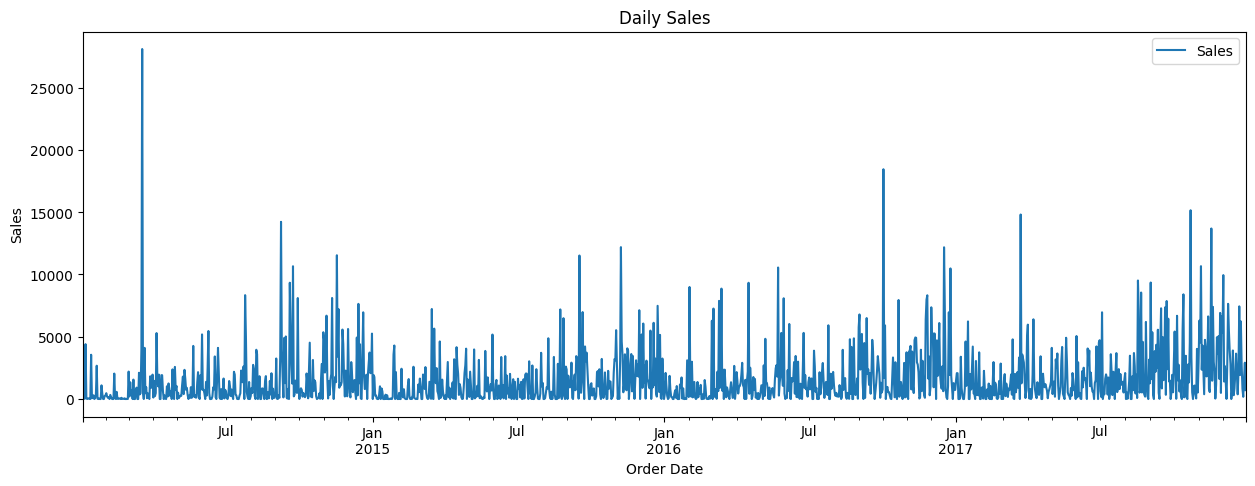

ADF Statistic: -4.939878803531315
p-value: 2.914879072767366e-05


In [13]:
daily_sales.plot(figsize=(15,5), title='Daily Sales')
plt.ylabel("Sales")
plt.show()

result = adfuller(daily_sales['Sales'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


In [14]:
daily_sales_diff = daily_sales['Sales'].diff().dropna()

result_diff = adfuller(daily_sales_diff)
print(f"ADF Statistic after differencing: {result_diff[0]}")
print(f"p-value after differencing: {result_diff[1]}")


ADF Statistic after differencing: -14.328105676259034
p-value after differencing: 1.1117457108698413e-26


In [15]:
train = daily_sales[:-30]
test = daily_sales[-30:]

# Define and fit SARIMA model
model = SARIMAX(train['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                 1428
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -12893.206
Date:                            Fri, 03 Oct 2025   AIC                          25796.413
Time:                                    12:42:43   BIC                          25822.687
Sample:                                01-03-2014   HQIC                         25806.229
                                     - 11-30-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0358      0.025      1.440      0.150      -0.013       0.084
ma.L1         -0.9554      0.010    -99.272      0.000      -0.974      -0.937
ar.S.L12      -0.0499      0.027     -1.825      0.068      -0.103       0.004
ma.S.L12      -0.9996      0.012    -84.446      0.000      -1.023      -0.976
sigma2      4.636e+06   2.58e-09    1.8e+15      0.000    4.64e+06    4.64e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             29187.08
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             3.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.01e+29. Standard errors may be unstable.
"""

In [17]:
pred_test = results.get_prediction(start=test.index[0], end=test.index[-1])
predicted_test = pred_test.predicted_mean

forecast = results.get_forecast(steps=30)
future_index = pd.date_range(start=daily_sales.index[-1] + timedelta(days=1), periods=30)
forecast_series = pd.Series(forecast.predicted_mean.values, index=future_index)


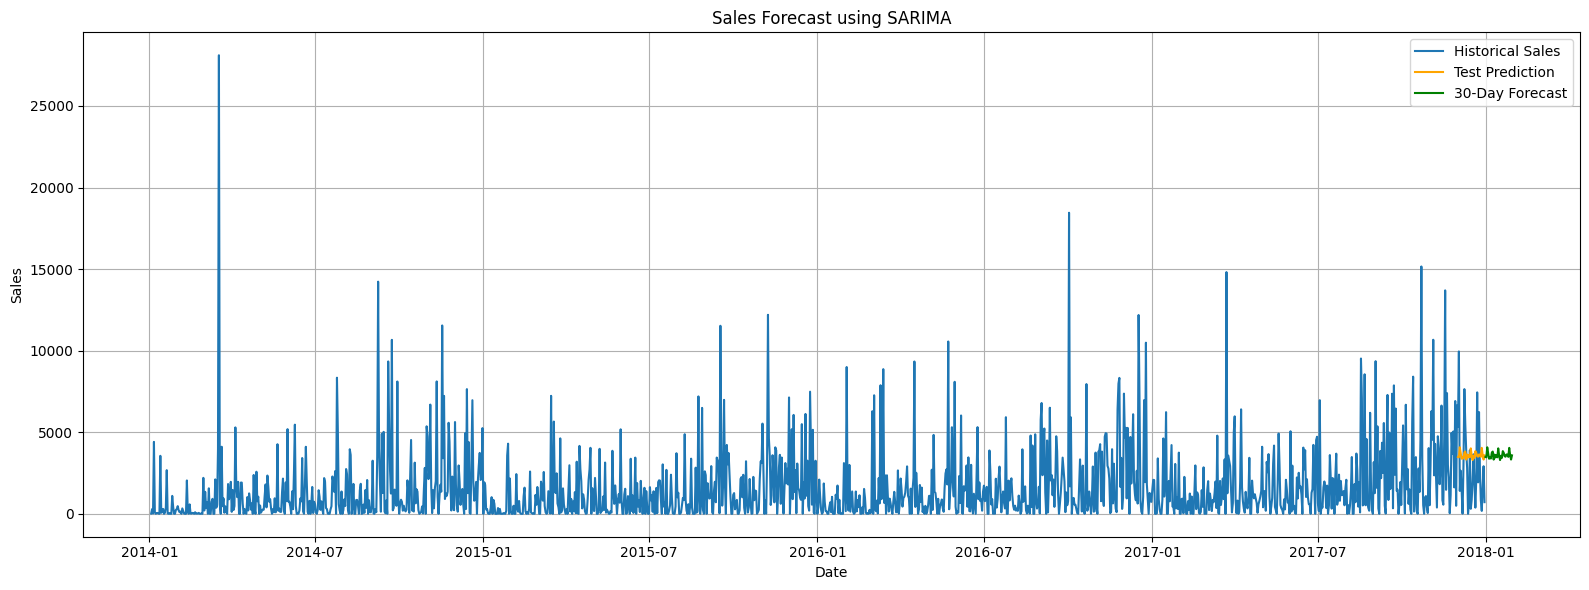

In [18]:
plt.figure(figsize=(16,6))

plt.plot(daily_sales.index, daily_sales['Sales'], label='Historical Sales')

plt.plot(predicted_test.index, predicted_test, label='Test Prediction', color='orange')

plt.plot(forecast_series.index, forecast_series, label='30-Day Forecast', color='green')

plt.title("Sales Forecast using SARIMA")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
forecast_series.to_frame(name='Forecasted Sales').to_csv('30_day_sales_forecast.csv')
